In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('EDA_Data.csv', index_col = 0)

In [3]:
df.head()

,main_category,currency,goal,state,backers,country,usd_pledged,total_days
0,Publishing,GBP,1000.0,failed,0,GB,0.0,58.0
1,Film & Video,USD,45000.0,failed,3,US,220.0,45.0
2,Music,USD,5000.0,failed,1,US,1.0,30.0
3,Film & Video,USD,19500.0,canceled,14,US,1283.0,55.0
4,Food,USD,50000.0,successful,224,US,52375.0,35.0


In [4]:
df.dtypes

main_category     object
currency          object
goal             float64
state             object
backers            int64
country           object
usd_pledged      float64
total_days       float64
dtype: object

In [5]:
#separating the categorical/object data types

dfo = df[['main_category', 'currency', 'country']]

In [6]:
#getting dummies for categoritcal values and adding to the main dataframe while deleting the original features

df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

In [7]:
#creating X and y values, since we are trying to predict the state of the project, this will be our y

X = df.drop('state', axis = 1)
y = df['state']

In [8]:
#splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# DecisionTreeClassifier

In [9]:
#finding the best max_depth parameter through gridsearch

#decision_tree = DecisionTreeClassifier()
#grid_param = {'max_depth': np.arange(3,10),}
#can try to add max_samples_split or max_samples_leaf but it might be computationally expensive and take a lot of time. 

#tree_gridsearchcv = GridSearchCV(decision_tree, grid_param)

#tree_gridsearchcv.fit(X_train, y_train)
#tree_gridsearchcv.best_params_

In [10]:
#retraining decision tree model based off of best max_depth param of 9
#do we need to retrain, or can we use the tree_gridsearchcv to predict? 

decision_tree = DecisionTreeClassifier(max_depth = 9)
decision_tree = decision_tree.fit(X_train, y_train)
tree_y_pred = decision_tree.predict(X_test)


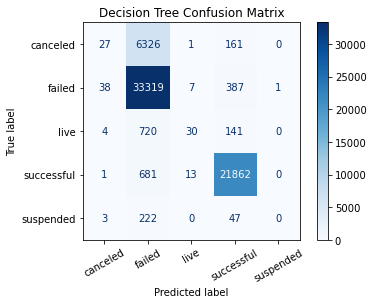

In [11]:
from sklearn import metrics

metrics.plot_confusion_matrix(decision_tree, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.xticks(rotation=30)
plt.show()

The confusion matrix shows that our model was pretty great at predicting which projects failed, did decently to predict which projects were successful, but everything lese, the model did a poor job of predicting correctly. For the most part, this isn't too bad, but for example, the 681 that were true successfuls, but our tree model predicted that it failed, that is an area we might be able tune a bit more for better results. 

In [12]:
print(metrics.classification_report(y_test, tree_y_pred))

#how do you know which average to use? micro, macro, or weighted 

              precision    recall  f1-score   support

    canceled       0.37      0.00      0.01      6515
      failed       0.81      0.99      0.89     33752
        live       0.59      0.03      0.06       895
  successful       0.97      0.97      0.97     22557
   suspended       0.00      0.00      0.00       272

    accuracy                           0.86     63991
   macro avg       0.55      0.40      0.39     63991
weighted avg       0.81      0.86      0.81     63991



In [13]:
#should we create a roc or auc for multiclass problem? 

Let's try rerunning everything after changing y to a binary class instead of keeping it multiclass 

In [14]:
from sklearn import preprocessing 
y2 = preprocessing.label_binarize(y, classes = ['successful'])

In [15]:
#retraining classifier since the y is now binary class
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size = 0.2, random_state = 42)
decision_tree = decision_tree.fit(X_train2, y_train2)
tree_y_pred2 = decision_tree.predict(X_test2)

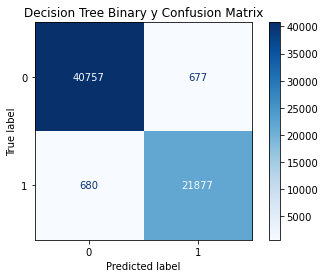

In [16]:
metrics.plot_confusion_matrix(decision_tree, X_test2, y_test2, cmap=plt.cm.Blues)
plt.title('Decision Tree Binary y Confusion Matrix')
plt.show()

In [17]:
print(metrics.classification_report(y_test2, tree_y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     41434
           1       0.97      0.97      0.97     22557

    accuracy                           0.98     63991
   macro avg       0.98      0.98      0.98     63991
weighted avg       0.98      0.98      0.98     63991



If we compare the results of multicalss vs binary for the target variable, the 'successful' score is about the same at .97 for both precision and recall, but by creating a binary target variable, the precision and recall for nonpositive or 'failed/canceled, etc.' labels score is higher in precision. 

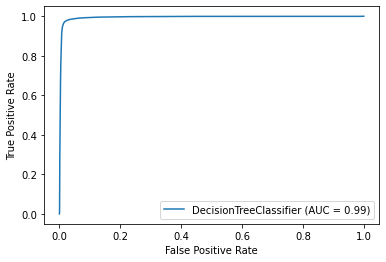

In [18]:
metrics.plot_roc_curve(decision_tree, X_test2, y_test2)
plt.show()

In [19]:
auc = metrics.roc_auc_score(y_test2, decision_tree.predict_proba(X_test2)[:,1])
print("AUC:",auc)

AUC: 0.9943845095730613


# RandomForestClassifier 


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier(n_estimators = 100, max_depth = 9)


In [21]:
#can we use the same max depth as before? or should we do another gridsearch to figure it out for this classifier 

#param_grid = {'max_depth': np.arange()}
#forest_randomsearchcv = RandomizedSearchCV(forest, param_grid)
#forest_randomsearchcv.fit(X_train, y_train)
#forest_randomsearchcv.best_params_

In [22]:
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)

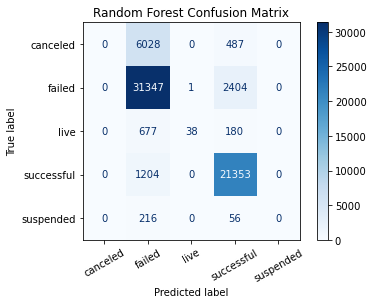

In [23]:
metrics.plot_confusion_matrix(forest, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.xticks(rotation=30)
plt.show()

In [24]:
print(metrics.classification_report(y_test, forest_y_pred))

C:\Users\blee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    canceled       0.00      0.00      0.00      6515
      failed       0.79      0.93      0.86     33752
        live       0.97      0.04      0.08       895
  successful       0.87      0.95      0.91     22557
   suspended       0.00      0.00      0.00       272

    accuracy                           0.82     63991
   macro avg       0.53      0.38      0.37     63991
weighted avg       0.74      0.82      0.77     63991



Now let's try running random forest as a binary classifier 

In [25]:
forest.fit(X_train2, y_train2)
forest_y_pred2 = forest.predict(X_test2)

<ipython-input-25-d391109edb05>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train2, y_train2)


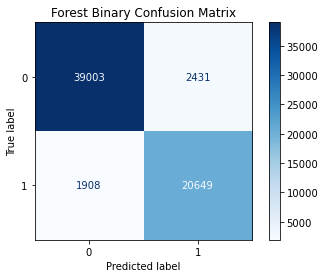

In [26]:
metrics.plot_confusion_matrix(forest, X_test2, y_test2, cmap=plt.cm.Blues)
plt.title('Forest Binary Confusion Matrix')
plt.show()

In [27]:
print(metrics.classification_report(y_test2, forest_y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     41434
           1       0.89      0.92      0.90     22557

    accuracy                           0.93     63991
   macro avg       0.92      0.93      0.93     63991
weighted avg       0.93      0.93      0.93     63991



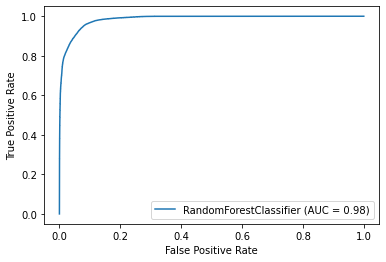

In [28]:
metrics.plot_roc_curve(forest, X_test2, y_test2)
plt.show()

In [29]:
auc = metrics.roc_auc_score(y_test2, forest.predict_proba(X_test2)[:,1])
print("AUC:",auc)

AUC: 0.9848725898530842
